<a href="https://colab.research.google.com/github/Reventh-Sharma/NNFL-Project/blob/master/Copy_of_cnn_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Network using an Optimized Backpropagation Technique
It has been observed that training CNNs using vanilla backprogatation doesn't ensure good performance, since the objjective function is not close to the global minimum. Attempts to improve this can be made by ensuring that the gradient optimization technique tries to accurately model attempts at moving to the global minimum, despite continual changes to the gradients and the Network parameters.

This experiment attempts to demonstrate the working of two commonly used gradient descent optimizers during the backpropagation process.

We consider two optimizers, namely the:
* AdaDelta Optimizer
* RMSProp Optimizer

We shall compare the performance of these two well studied optimizers, to verify that the optimized backpropagation technique brings us very good validation results.

## Dataset Used
We will be using the **COIL-100** Dataset, consisting of exactly 100 images, each having 72 augmentations. This technique of data augmentation is necessary, since the original dataset of 100 immages is too small to generalize well.

The dataset resides in the `./dataset/coil-100` directory. We'll be using a generator to generate images and load it onto the main training loop.

In [2]:
import pandas as pd
import numpy as np
import glob
import os
import pathlib
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import math
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense, Activation, Conv2D, AveragePooling2D, Flatten, Dropout, Reshape

from tensorflow.python.framework.ops import disable_eager_execution

# Disable eager execution
disable_eager_execution()

# Batch Generator
This is a function which generates images in a batch-wise manner, specified by the batch size. While this is not required in this problem, since we could load the entire dataset at once into memory, it is still a good practice to used similar functions, especially if your dataset cannot fit into memory.

This loads images from `directory`, and splits it into **training_images: validation_images** at the default ratio of `0.7:0.3`

We associate a label for each image, and the labels are also generated along with the images.

In [10]:
def generate_images(directory, batch_size, labels, shuffle, target_size, rescale=1./255, validation_split=0.3, fmt='png'):
    # Batch Generator -> Generates Numpy arrays from corresponding images after scaling
    if not isinstance(target_size, tuple):
        raise TypeError("Expected Tuple")
    assert validation_split <= 0.5
    
    data_path = pathlib.Path(directory)
    images = list(data_path.glob("*." + fmt))
    num_images = len(images)
    
    # A Label for each image
    print(labels.shape[0], num_images)
    assert num_images == labels.shape[0]

    idx = 0

    images = np.array(images)
    inds = np.arange(num_images)
    
    if shuffle:
        np.random.shuffle(inds)
        images, labels = images[inds], labels[inds]
        # random.shuffle(images)
    
    val_size = math.ceil(batch_size * (validation_split))
    train_size = batch_size - val_size
    
    while True:
        print("Loop running")
        image_batch_train = np.zeros((train_size,) + target_size, dtype='float') # target_size is already a tuple
        label_batch_train = np.zeros((train_size, labels.shape[1]))
        image_batch_val = np.zeros((val_size,) + target_size, dtype='float')
        label_batch_val = np.zeros((val_size, labels.shape[1]))
        for i in range(train_size):
            print("Train Batch:", i)
            if idx == num_images:
                idx = 0
                # random.shuffle(images)
                np.random.shuffle(inds)
                images, labels = images[inds], labels[inds]
            img = images[idx]
            image = np.asarray(Image.open(img)).reshape(target_size) * rescale
            image_batch_train[i] = image
            label_batch_train[i] = labels[idx]
            idx += 1
        for i in range(train_size, batch_size):
            print("Val Batch:", i)
            if idx == num_images:
                # Reset index and shuffle if we reach the end of the dataset
                idx = 0
                # random.shuffle(images)
                np.random.shuffle(inds)
                images, labels = images[inds], labels[inds]
            img = images[idx]
            image = np.asarray(Image.open(img)).reshape(target_size) * rescale
            image_batch_val[i - train_size] = image
            label_batch_val[i - train_size] = labels[idx]
            idx += 1
        # Yield a generator for both the training as well as the validation set of images
        yield image_batch_train, label_batch_train, image_batch_val, label_batch_val

* This helper function converts a numpy `ndarray` to a `PIL` image, for visualizing any output. While this is not directly used in the final experiment, we used this to verify that we were getting the correct outputs from our Network.

In [4]:
def numpy_to_img(normalized_img, scale=255.0):
    # The original array is normalized, so scale it again
    # RGB Mode expects uint8
    image = Image.fromarray((normalized_img * scale).astype('uint8'))
    return image

# One-Hot-Encoding Trick
For small datasets, the One Hot Encoding trick converts a scalar label into a vector. This is quite useful, since we can directly correlate the softmax output to the one-hot-vector, having the same dimensions. While this does not work for large datasets, we can take advantage of this technique quite clearly in our experiments.

* Originally, the labels were simply a number between 0 to 100. Since the number of images are small, we can directly convert them into a one-hot encoding format. This `one_hot_encoder()` function vectorizes a scalar label, and returns the one hot encoding of the labelled dataset.

In [5]:
def one_hot_encoder(label_dataset):
  """
    Takes a labelled dataset of the form: [ 0 0 0 ... 1 1 1 ... 100 100 100 ... ]
    and returns a one-hot encoding representation of the labelled data
  """
  unique_labels = np.unique(label_dataset)
  one_hot_labels = np.zeros((label_dataset.shape[0], unique_labels.shape[0]))
  label_dataset = np.repeat(label_dataset, unique_labels.shape[0]).reshape(-1, unique_labels.shape[0])
  one_hot_labels[np.where(label_dataset == unique_labels)] = 1
  return one_hot_labels

# Generating the Models

We have two models to compare: one using the Adadelta optimizer, and the other, using the RMSProp Optimizer.
The models are almost the same. The main structure difference is that the RMSProp has 50 weights for the second-last Dense layer, while the Adadelta has 100. Other that that, there are some hyperparameters specific to both the models.

Due to this, plus the fact that the RMSProp Optimizer uses a constant learning rate, we would generally expect the RMSProp model to converge faster than the Adadelta, although the performance wouldn't differ by much.

In [49]:
def generate_model(optimizer):
    if optimizer == 'SGD':
        optimizer = tf.keras.optimizers.SGD(
            learning_rate=0.01, name='SGD')
        model = models.Sequential()
        model.add(layers.Conv2D(10, (3, 3), activation='relu', input_shape=(128, 128, 3)))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(5, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Flatten())
        model.add(layers.Dense(50, activation='relu'))
        model.add(layers.Dense(label_train.shape[1], activation='softmax'))
        model.compile(optimizer=optimizer,
                      loss=tf.keras.losses.CategoricalCrossentropy(),
                      metrics=['accuracy'])
        return model
    elif optimizer == 'Adadelta':
        optimizer = tf.keras.optimizers.Adadelta(
            learning_rate=0.024, rho=0.96, epsilon=1e-03, name='Adadelta')
        model = models.Sequential()
        model.add(layers.Conv2D(10, (3, 3), activation='relu', input_shape=(128, 128, 3)))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(5, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Flatten())
        model.add(layers.Dense(50, activation='relu'))
        model.add(layers.Dense(label_train.shape[1], activation='softmax'))
        model.compile(optimizer=optimizer,
                      loss=tf.keras.losses.CategoricalCrossentropy(),
                      metrics=['accuracy'])
        return model
    elif optimizer == 'RMSprop':
        optimizer = tf.keras.optimizers.RMSprop(
            learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, name='RMSprop')
        model = models.Sequential()
        model.add(layers.Conv2D(10, (3, 3), activation='relu', input_shape=(128, 128, 3)))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(5, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Flatten())
        model.add(layers.Dense(50, activation='relu'))
        model.add(layers.Dense(label_train.shape[1], activation='softmax'))
        model.compile(optimizer=optimizer,
                      loss=tf.keras.losses.CategoricalCrossentropy(),
                      metrics=['accuracy'])
        return model
    elif optimizer == 'Adam':
        optimizer = tf.keras.optimizers.Adam(
          learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Adam')
        model = models.Sequential()
        model.add(layers.Conv2D(10, (3, 3), activation='relu', input_shape=(128, 128, 3)))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(5, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Flatten())
        model.add(layers.Dense(50, activation='relu'))
        model.add(layers.Dense(label_train.shape[1], activation='softmax'))
        model.compile(optimizer=optimizer,
                      loss=tf.keras.losses.CategoricalCrossentropy(),
                      metrics=['accuracy'])
        return model
    else:
        raise ValueError("Only SGD, Adadelta, RMSprop, Adam optimizers are allowed")

In [15]:
BATCH_SIZE

7200

## The Main Function


In [ ]:
if __name__ == '__main__':
    data_path = '/content/drive/My Drive/Assignments/NNFL/dataset/coil-100'
    # Path to all images
    images = pathlib.Path(data_path).glob("*.png")
    image_data = list(images)

    CLASS_LABELS = list([int(''.join(item.name.split('_')[0].lstrip('obj'))) for item in image_data])
    CLASS_LABELS = np.array((CLASS_LABELS))
    CLASS_LABELS = one_hot_encoder(CLASS_LABELS)
    
    # Define parameters for batch generation
    BATCH_SIZE = len(image_data)
    IMAGE_WIDTH, IMAGE_HEIGHT = 128, 128
    NUM_CHANNELS = 3 # RGB Image has 3 channels

    # Use the batch generator. This outputs (train_images, val_images)
    gen = generate_images(directory=str(data_path), batch_size=BATCH_SIZE,
                            labels=CLASS_LABELS,
                            shuffle=True, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CHANNELS),
                            validation_split=0.3)

    # Example generation. This generates a single batch of training and validation images
    batch_train, label_train, batch_val, label_val = next(gen)

# Generate the SGD Model

In [38]:
model = generate_model('SGD')
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 126, 126, 10)      280       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 63, 63, 10)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 61, 61, 5)         455       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 30, 30, 5)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 4500)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 50)                225050    
_________________________________________________________________
dense_9 (Dense)              (None, 100)              

# Fit the model on the Dataset

In [39]:
history = model.fit(batch_train, label_train, epochs=20, batch_size=50,
                    validation_data=(batch_val, label_val))

Train on 5040 samples, validate on 2160 samples
Epoch 1/20
5040/5040 [==============================] - 2s 477us/sample - loss: 4.5588 - accuracy: 0.0347 - val_loss: 4.4751 - val_accuracy: 0.0509
Epoch 2/20
5040/5040 [==============================] - 2s 435us/sample - loss: 4.2717 - accuracy: 0.0845 - val_loss: 3.9570 - val_accuracy: 0.1023
Epoch 3/20
5040/5040 [==============================] - 2s 452us/sample - loss: 3.3805 - accuracy: 0.2208 - val_loss: 2.7229 - val_accuracy: 0.3560
Epoch 4/20
5040/5040 [==============================] - 2s 447us/sample - loss: 2.0922 - accuracy: 0.4810 - val_loss: 1.3817 - val_accuracy: 0.6593
Epoch 5/20
5040/5040 [==============================] - 2s 437us/sample - loss: 1.1712 - accuracy: 0.7060 - val_loss: 0.9202 - val_accuracy: 0.7519
Epoch 6/20
5040/5040 [==============================] - 2s 438us/sample - loss: 0.6345 - accuracy: 0.8331 - val_loss: 0.4274 - val_accuracy: 0.8884
Epoch 7/20
5040/5040 [==============================] - 2s 433us

In [40]:
model.save_weights('sgd_model_weights.h5')

# Plot results (SGD)

# Experiment (`batch_size = 50`)

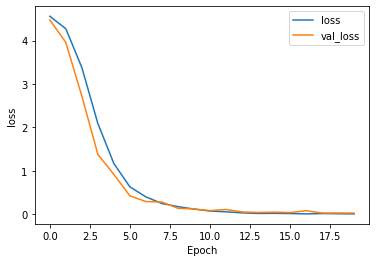

In [41]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')

test_loss, test_acc = model.evaluate(batch_val,  label_val, verbose=2)

In [42]:
print(test_loss, test_acc)

0.031799544980404555 0.9912037


# Generate the Adadelta Model

In [50]:
model = generate_model('Adadelta')
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 126, 126, 10)      280       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 63, 63, 10)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 61, 61, 5)         455       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 30, 30, 5)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 4500)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 50)                225050    
_________________________________________________________________
dense_15 (Dense)             (None, 100)              

# Fit the model on the Dataset

In [51]:
history = model.fit(batch_train, label_train, epochs=20, batch_size=50,
                    validation_data=(batch_val, label_val))

Train on 5040 samples, validate on 2160 samples
Epoch 1/20
5040/5040 [==============================] - 2s 459us/sample - loss: 4.5523 - accuracy: 0.0341 - val_loss: 4.3722 - val_accuracy: 0.0671
Epoch 2/20
5040/5040 [==============================] - 2s 437us/sample - loss: 3.8219 - accuracy: 0.1435 - val_loss: 2.9757 - val_accuracy: 0.2569
Epoch 3/20
5040/5040 [==============================] - 2s 441us/sample - loss: 2.1599 - accuracy: 0.4504 - val_loss: 1.2948 - val_accuracy: 0.6602
Epoch 4/20
5040/5040 [==============================] - 2s 440us/sample - loss: 1.0117 - accuracy: 0.7343 - val_loss: 0.7980 - val_accuracy: 0.7764
Epoch 5/20
5040/5040 [==============================] - 2s 437us/sample - loss: 0.5105 - accuracy: 0.8625 - val_loss: 0.4347 - val_accuracy: 0.8764
Epoch 6/20
5040/5040 [==============================] - 2s 444us/sample - loss: 0.2169 - accuracy: 0.9401 - val_loss: 0.2720 - val_accuracy: 0.9171
Epoch 7/20
5040/5040 [==============================] - 2s 451us

In [52]:
model.save_weights('adadelta_model_weights.h5')

# Plot results (Adadelta)

# Experiment (`batch_size = 50`)

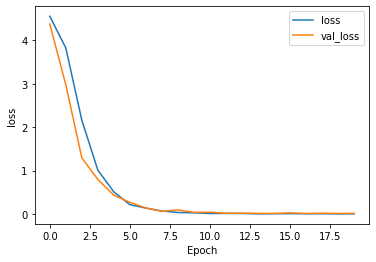

In [53]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')

test_loss, test_acc = model.evaluate(batch_val,  label_val, verbose=2)

In [54]:
print(test_loss, test_acc)

0.017640984900019786 0.99444443


# Generate the RMSprop Model

In [55]:
model = generate_model('RMSprop')
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 126, 126, 10)      280       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 63, 63, 10)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 61, 61, 5)         455       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 30, 30, 5)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 4500)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 50)                225050    
_________________________________________________________________
dense_17 (Dense)             (None, 100)              

# Fit the Model using RMSprop Optimizer

In [56]:
history = model.fit(batch_train, label_train, epochs=20, batch_size=50,
                    validation_data=(batch_val, label_val))

Train on 5040 samples, validate on 2160 samples
Epoch 1/20
5040/5040 [==============================] - 2s 480us/sample - loss: 3.6648 - accuracy: 0.1865 - val_loss: 2.4758 - val_accuracy: 0.3361
Epoch 2/20
5040/5040 [==============================] - 2s 442us/sample - loss: 1.3607 - accuracy: 0.6605 - val_loss: 0.8130 - val_accuracy: 0.7704
Epoch 3/20
5040/5040 [==============================] - 2s 443us/sample - loss: 0.5765 - accuracy: 0.8536 - val_loss: 0.3199 - val_accuracy: 0.9259
Epoch 4/20
5040/5040 [==============================] - 2s 442us/sample - loss: 0.2965 - accuracy: 0.9185 - val_loss: 0.2318 - val_accuracy: 0.9394
Epoch 5/20
5040/5040 [==============================] - 2s 430us/sample - loss: 0.1844 - accuracy: 0.9452 - val_loss: 0.2949 - val_accuracy: 0.9060
Epoch 6/20
5040/5040 [==============================] - 2s 443us/sample - loss: 0.1356 - accuracy: 0.9607 - val_loss: 0.1684 - val_accuracy: 0.9426
Epoch 7/20
5040/5040 [==============================] - 2s 434us

In [57]:
model.save_weights('rmsprop_model_weights.h5')

# Plot Results (RMSprop)

# Experiment (`batch_size = 50`)

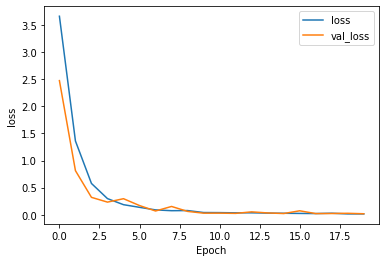

In [58]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')

test_loss, test_acc = model.evaluate(batch_val,  label_val, verbose=2)

In [59]:
print(test_loss, test_acc)

0.016895034551810198 0.99583334


# Generate the RMSprop Model

In [60]:
model = generate_model('Adam')
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 126, 126, 10)      280       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 63, 63, 10)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 61, 61, 5)         455       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 30, 30, 5)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 4500)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 50)                225050    
_________________________________________________________________
dense_19 (Dense)             (None, 100)              

# Fit the Model using Adam Optimizer

In [61]:
history = model.fit(batch_train, label_train, epochs=20, batch_size=50,
                    validation_data=(batch_val, label_val))

Train on 5040 samples, validate on 2160 samples
Epoch 1/20
5040/5040 [==============================] - 2s 459us/sample - loss: 3.2848 - accuracy: 0.2619 - val_loss: 1.3797 - val_accuracy: 0.6519
Epoch 2/20
5040/5040 [==============================] - 2s 429us/sample - loss: 0.7651 - accuracy: 0.7935 - val_loss: 0.4140 - val_accuracy: 0.8852
Epoch 3/20
5040/5040 [==============================] - 2s 419us/sample - loss: 0.2883 - accuracy: 0.9179 - val_loss: 0.2070 - val_accuracy: 0.9472
Epoch 4/20
5040/5040 [==============================] - 2s 420us/sample - loss: 0.1439 - accuracy: 0.9619 - val_loss: 0.0822 - val_accuracy: 0.9833
Epoch 5/20
5040/5040 [==============================] - 2s 425us/sample - loss: 0.0717 - accuracy: 0.9853 - val_loss: 0.0643 - val_accuracy: 0.9792
Epoch 6/20
5040/5040 [==============================] - 2s 429us/sample - loss: 0.0720 - accuracy: 0.9815 - val_loss: 0.0625 - val_accuracy: 0.9912
Epoch 7/20
5040/5040 [==============================] - 2s 434us

In [63]:
model.save_weights('adam_model_weights.h5')

# Plot Results (Adam)

# Experiment (`batch_size = 50`)

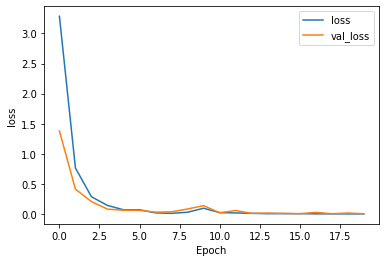

In [64]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')

test_loss, test_acc = model.evaluate(batch_val,  label_val, verbose=2)

In [65]:
print(test_loss, test_acc)

0.005791762543419652 0.9990741


# Load the PreTrained Weights
This function loads the previously trained weights for both the models, from the files `adadelta_model_weights.h5` and `rmsprop_model_weights.h5`.

You can load the model from these weights and test them on sample images.

In [76]:
def load_model(type):
    if type == "SGD":
        model = generate_model("Adadelta")
        model.load_weights('sgd_model_weights.h5')
        return model
    elif type == "Adadelta":
        model = generate_model("Adadelta")
        model.load_weights('adadelta_model_weights.h5')
        return model
    elif type == "RMSprop":
        model = generate_model("RMSprop")
        model.load_weights('rmsprop_model_weights.h5')
        return model
    elif type == "Adam":
        model = generate_model("Adam")
        model.load_weights('adam_model_weights.h5')
        return model
    else:
        raise ValueError("Only SGD, Adagrad, RMSprop and ADAM models supported")

# Test the Model
This function tests the model on some sample images randomly taken from the batch generator function. This returns the prediction for every sample test image, along with their corresponding labels and images. We can use this to verify the correctness of our model.

In [70]:
def test_model(model, data_path, num_samples):
    gen = generate_images(directory=str(data_path), batch_size=num_samples,
                            labels=CLASS_LABELS,
                            shuffle=True, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CHANNELS),
                            validation_split=0)
    # We don't need any validation images, since this is test-time
    test_images, test_labels, _, _ = next(gen)
    # Make the prediction using the model
    predictions = model.predict(test_images)

    test_images = test_images.reshape(test_images.shape[0], -1)

    def convert_to_image(img_arr, target_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CHANNELS), scale=255.0):
        # The original array is normalized, so scale it again
        # RGB Mode expects uint8
        image = Image.fromarray((img_arr.reshape(target_shape) * scale).astype('uint8'))
        return image
    
    return np.apply_along_axis(np.argmax, arr=predictions, axis=1), np.apply_along_axis(convert_to_image, arr=test_images, axis=1), test_labels

## Load and Test the $Adadelta$ model

In [ ]:
model = load_model('Adadelta')
predictions, test_images, test_labels = test_model(model, data_path, num_samples=10)

Predicted Label: 71
Actual Label: 71


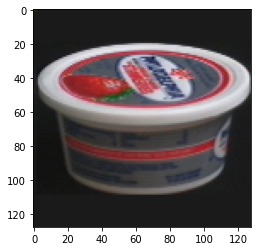

In [72]:
# Example Image for testing the Model
print(f"Predicted Label: {predictions[0]}")
print(f"Actual Label: {np.argmax(test_labels[0])}")
plt.imshow(test_images[0])

## Load and Test the $RMSprop$ Model:

In [ ]:
model = load_model('RMSprop')
predictions, test_images, test_labels = test_model(model, data_path, num_samples=10)

Predicted Label: 98
Actual Label: 98


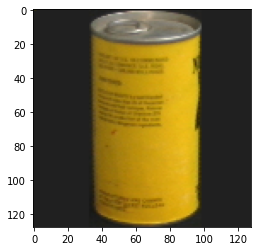

In [74]:
# Example Image for testing the Model
print(f"Predicted Label: {predictions[0]}")
print(f"Actual Label: {np.argmax(test_labels[0])}")
plt.imshow(test_images[0])

## Load and Test the $Adam$ Model:

In [ ]:
model = load_model('Adam')
predictions, test_images, test_labels = test_model(model, data_path, num_samples=10)

Predicted Label: 81
Actual Label: 81


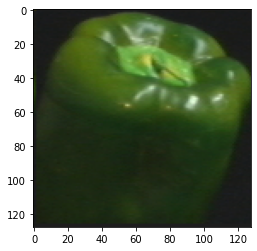

In [82]:
# Example Image for testing the Model
print(f"Predicted Label: {predictions[0]}")
print(f"Actual Label: {np.argmax(test_labels[0])}")
plt.imshow(test_images[0])

# Conclusion

As you can observe, the validation accuracy of both the optimizers are very similar, indicating that the reach very similar minima.

We can see that overall, AdaDelta can possibly generalize better than RMSProp for our small dataset, since $Accuracy_{adadelta} = 0.9958$, while $Accuracy_{rmsprop} = 0.9912$.

However, the loss of `AdaDelta` ($Loss_{adadelta}$) = 0.015, while the loss of `RMSProp` ($Loss_{rmsprop}$) = 0.033. This means that overall, the AdaDelta optimizer has reached a point closer to the global minima, as compared to RMSProp. This better converge has a cost, with a higher number of epochs required to tackle the vanishing gradients problem, when the gradients are close to zero. RMSProp does not face this issue, since it has a constant learning rate $\eta = 0.001$.

While the applicability of these two optimizers varies depending on the problem, for our small scale CNN, we indeed observed that AdaDelta fares the best among the two, although we set a do a lot of epochs in training to beat the RMSProp optimizer.